In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

# This notebook is for a data analysis from the dataset "Titanic - Machine Learning" from Disaster from Kaggle - SCORE: 0.77751

The idea behind this dataset is to create a algorithm that can predict if a certain passenger was able to survive or not base on the features presented. There are already a training and a test subsets to work with.

Since this is a yes/no type of question, a classification algorithm suits our proposed, and that can be done by using logistic regression.

First, lets take a look at the information available by loading both training and test and than merging them into one big group.

In [2]:
#import data
raw_train_data = pd.read_csv('train.csv')
raw_test_data = pd.read_csv('test.csv')
all_raw_data = pd.concat([raw_train_data,raw_test_data],ignore_index=True)
all_raw_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
raw_train_data.shape

(891, 12)

As we can see, that are 10 features and the target "Survived". Feature "PassengerId" has not meaningful information for analysis, so it will be ignored. Features "Pclass", "Ticket", "Fare" and "Cabin" pass almost the same information: they all separate the passenger amount different (social) classes within Titanic. To simplify analysis, only "Pclass" (discrete numeric data) and Ticket (continuous numeric data). "Name" will not be important and for now. "Embarked" representd the port were each person board at Titanic (nominal categorical data) and will be considerer (altought it can also reflect the social class of each passenger). Since "SibSp" and "Parch" represents different ways to tell if one person travel alone or not we will build a single columns with 1/0 to represent that

So, the analysis will start use the following features:

"Pclass" / "Sex" / "Age" / "Fare" / "Embarked" / "TravelAlone"

We can observe that there is missing data at some columns, so lets make sense who we can cope them.

In [4]:
#Check missing values
all_raw_data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

So, for the features that will be used to build our model, only age present a high amount of missing information. We can try to supply this missing information with the median of age based on "Pclass" and "Sex".

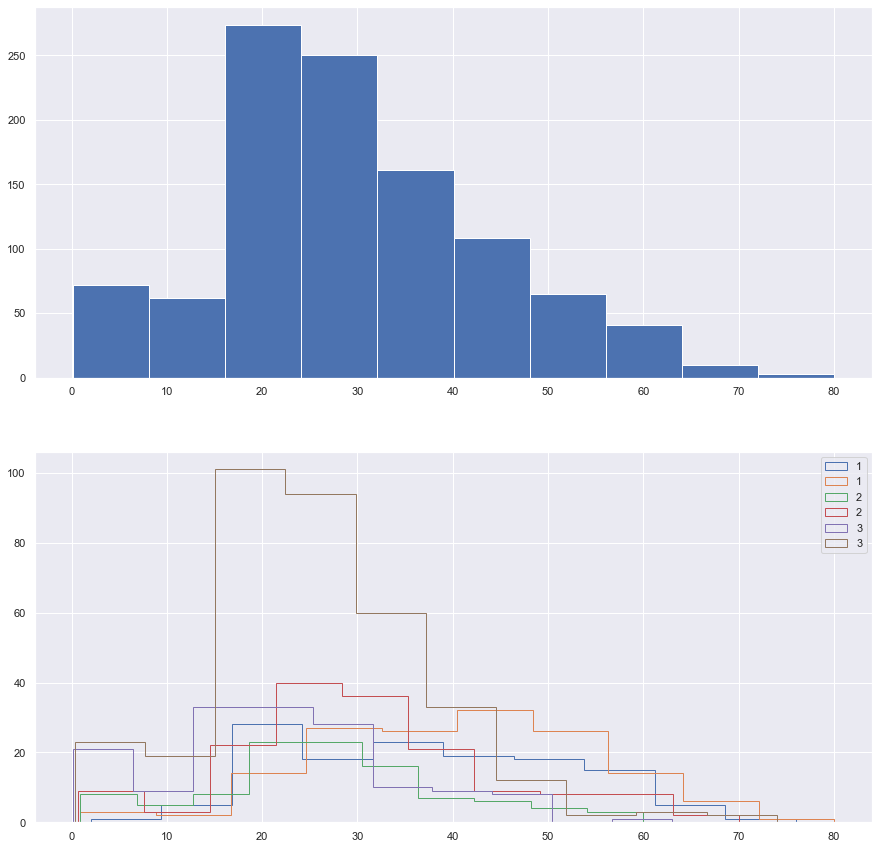

In [5]:
#plot age distribution
plt.figure(figsize=(15,15))

plt.subplot(2,1,1)
all_raw_data["Age"].hist() #general

plt.subplot(2,1,2)
all_raw_data.groupby(['Pclass','Sex'])['Age'].hist(histtype='step',legend=True)
plt.show()

Both plots show that there are a slight difference at age medians when considering the groupoing done. This difference must be reflected at the data, so:

In [6]:
#Working with ages
#Apply median for ages with NaN
process_data = all_raw_data.copy()
process_data['Age'] = all_raw_data.groupby(['Pclass','Sex'])['Age'].apply(lambda x: x.fillna(x.median()))
process_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
#Check missing values
process_data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Now, we will replace the two missing embarked locating with the port with higher occurence:

In [8]:
#check class with higher frequency
print(all_raw_data['Embarked'].value_counts())

S    914
C    270
Q    123
Name: Embarked, dtype: int64


In [9]:
#Check missing values
process_data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Now, what is the best value to replace the one missing info at Fare? First, lets see who this missing sample is:

In [10]:
#check rows that have nan at Fare column
all_raw_data[all_raw_data['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


So, Mr.Thomas Storey is a passenger from "Pclass" 3 that embarked at port S. We can use this to see what is the mean ticket values for this group and attritube it to Mr. Thomas' "Fare".

In [11]:
#find the and replace Fare price for Mr. Thomas
fare_groups = all_raw_data.groupby(['Pclass','Embarked'])['Fare'].mean()
print(fare_groups)
process_data['Fare'] = all_raw_data['Fare'].fillna(fare_groups.iloc[-1])

Pclass  Embarked
1       C           106.845330
        Q            90.000000
        S            72.148094
2       C            23.300593
        Q            11.735114
        S            21.206921
3       C            11.021624
        Q            10.390820
        S            14.435422
Name: Fare, dtype: float64


In [12]:
#cofirm substitution
process_data.iloc[1043]

PassengerId                  1044
Survived                      NaN
Pclass                          3
Name           Storey, Mr. Thomas
Sex                          male
Age                          60.5
SibSp                           0
Parch                           0
Ticket                       3701
Fare                      14.4354
Cabin                         NaN
Embarked                        S
Name: 1043, dtype: object

In [13]:
#Check missing values
process_data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          2
dtype: int64

In [14]:
#drop columns
process_data = process_data.drop(['Ticket', 'Cabin'], axis=1)
process_data.shape

(1309, 10)

Now, lets see what we can take from feature "Name".It looks like this feature display the different title that people have and it can help differentiate passenger by their social class. First we need to know how many unique values we have and if any of them may have the same meaning.

In [15]:
#extracting titles
process_data['Title'] = process_data['Name'].str.extract('(\w+\.)')
process_data['Title'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Don.', 'Rev.', 'Dr.', 'Mme.',
       'Ms.', 'Major.', 'Lady.', 'Sir.', 'Mlle.', 'Col.', 'Capt.',
       'Countess.', 'Jonkheer.', 'Dona.'], dtype=object)

Title like 'Mlle.' and 'Miss.' have the same meaning, as 'Mme.' and 'Mrs.'. I will perform the grouping below show we can reduce the degree of freedom from this feature.

In [16]:
#replacing title
process_data['Title'] = process_data['Title'].replace(['Lady.', 'Countess.','Capt.', 'Col.',\
                                                       'Don.', 'Dr.', 'Major.', 'Rev.', 'Sir.',\
                                                       'Jonkheer.', 'Dona.'], 'Rare')
process_data['Title'] = process_data['Title'].replace('Mlle.', 'Miss.')
process_data['Title'] = process_data['Title'].replace('Ms.', 'Miss.')
process_data['Title'] = process_data['Title'].replace('Mme.', 'Mrs.')
process_data['Title'].unique()

array(['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Rare'], dtype=object)

Since there are a lot of categorical data, I need to transform them in a way that my future model can understand. Lets do it by getting dummy values for features "Title","Pclass","Embarked" and "Sex". After, I will drop features 'Name' and 'PassengerId' since I will not use them.

In [17]:
#get dummies for categorical features
process_data = pd.get_dummies(process_data,columns=["Title","Pclass","Embarked","Sex"])

In [18]:
#drop name and id
process_data = process_data.drop(['Name','PassengerId'],axis=1)
process_data.head()

,Survived,Age,SibSp,Parch,Fare,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Rare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,0.0,22.0,1,0,7.2500,0,0,1,0,0,0,0,1,0,0,1,0,1
1,1.0,38.0,1,0,71.2833,0,0,0,1,0,1,0,0,1,0,0,1,0
2,1.0,26.0,0,0,7.9250,0,1,0,0,0,0,0,1,0,0,1,1,0
3,1.0,35.0,1,0,53.1000,0,0,0,1,0,1,0,0,0,0,1,1,0
4,0.0,35.0,0,0,8.0500,0,0,1,0,0,0,0,1,0,0,1,0,1


For the feature "Age", I want to work with different age groups. The code below will perform that

In [19]:
#Create age bands
process_data['AgeBand'] = pd.cut(process_data['Age'], 5)
process_data[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(0.0902, 16.136]",0.550000
1,"(16.136, 32.102]",0.336714
2,"(32.102, 48.068]",0.412844
3,"(48.068, 64.034]",0.434783
4,"(64.034, 80.0]",0.090909


In [20]:
#Replacing ages
process_data.loc[process_data['Age'] <= 16, 'Age'] = 0 #first part find the row and second specify whitch column will be replace (=) by zero
process_data.loc[((process_data['Age'] > 16) & (process_data['Age'] <= 32)), 'Age'] = 1
process_data.loc[((process_data['Age'] > 32) & (process_data['Age'] <= 48)), 'Age'] = 2
process_data.loc[((process_data['Age'] > 48) & (process_data['Age'] <= 64)), 'Age'] = 3
process_data.loc[process_data['Age'] > 64, 'Age'] = 4

In [21]:
process_data.head(5)

,Survived,Age,SibSp,Parch,Fare,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Rare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,AgeBand
0,0.0,1.0,1,0,7.2500,0,0,1,0,0,0,0,1,0,0,1,0,1,"(16.136, 32.102]"
1,1.0,2.0,1,0,71.2833,0,0,0,1,0,1,0,0,1,0,0,1,0,"(32.102, 48.068]"
2,1.0,1.0,0,0,7.9250,0,1,0,0,0,0,0,1,0,0,1,1,0,"(16.136, 32.102]"
3,1.0,2.0,1,0,53.1000,0,0,0,1,0,1,0,0,0,0,1,1,0,"(32.102, 48.068]"
4,0.0,2.0,0,0,8.0500,0,0,1,0,0,0,0,1,0,0,1,0,1,"(32.102, 48.068]"


Next, lets create a column that will represent pleople that traveled alone or not and the family size.

In [22]:
process_data['TravelAlone']=np.where((all_raw_data["SibSp"]+all_raw_data["Parch"])>0, 0, 1)

In [24]:
process_data['FamilySize'] = process_data['SibSp'] + process_data['Parch'] + 1
process_data.head(5)

,Survived,Age,SibSp,Parch,Fare,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Rare,...,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,AgeBand,TravelAlone,FamilySize
0,0.0,1.0,1,0,7.2500,0,0,1,0,0,...,0,1,0,0,1,0,1,"(16.136, 32.102]",0,2
1,1.0,2.0,1,0,71.2833,0,0,0,1,0,...,0,0,1,0,0,1,0,"(32.102, 48.068]",0,2
2,1.0,1.0,0,0,7.9250,0,1,0,0,0,...,0,1,0,0,1,1,0,"(16.136, 32.102]",1,1
3,1.0,2.0,1,0,53.1000,0,0,0,1,0,...,0,0,0,0,1,1,0,"(32.102, 48.068]",0,2
4,0.0,2.0,0,0,8.0500,0,0,1,0,0,...,0,1,0,0,1,0,1,"(32.102, 48.068]",1,1


In [25]:
#drop unecessary columns
process_data = process_data.drop(['SibSp', 'Parch'],axis=1)

In [26]:
process_data = process_data.drop(['AgeBand'],axis=1)

In [27]:
process_data.head(5)

,Survived,Age,Fare,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Rare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,TravelAlone,FamilySize
0,0.0,1.0,7.2500,0,0,1,0,0,0,0,1,0,0,1,0,1,0,2
1,1.0,2.0,71.2833,0,0,0,1,0,1,0,0,1,0,0,1,0,0,2
2,1.0,1.0,7.9250,0,1,0,0,0,0,0,1,0,0,1,1,0,1,1
3,1.0,2.0,53.1000,0,0,0,1,0,1,0,0,0,0,1,1,0,0,2
4,0.0,2.0,8.0500,0,0,1,0,0,0,0,1,0,0,1,0,1,1,1


After all pre processing, it's time to prepear the logistic regression model.

In [28]:
#Split into training and test
training = process_data.iloc[:890,:]
test = process_data.iloc[891:,:]

In [29]:
#create variable to store all features' names
all_features = process_data.columns
all_features

Index(['Survived', 'Age', 'Fare', 'Title_Master.', 'Title_Miss.', 'Title_Mr.',
       'Title_Mrs.', 'Title_Rare', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male',
       'TravelAlone', 'FamilySize'],
      dtype='object')

In [30]:
#create x and y to determine what are the best features to use
x = training.iloc[:,1:]
y = training.iloc[:,0]

The code below will show how many and which one of the features that we decided to use are indeed relevant for the model

C:\Users\gnser\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\gnser\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Optimal number of features: 14
Selected features: ['Age', 'Title_Master.', 'Title_Miss.', 'Title_Mr.', 'Title_Mrs.', 'Title_Rare', 'Pclass_1', 'Pclass_3', 'Embarked_C', 'Embarked_S', 'Sex_female', 'Sex_male', 'TravelAlone', 'FamilySize']


C:\Users\gnser\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Text(0, 0.5, 'Cross validation score (nb of correct classifications)')

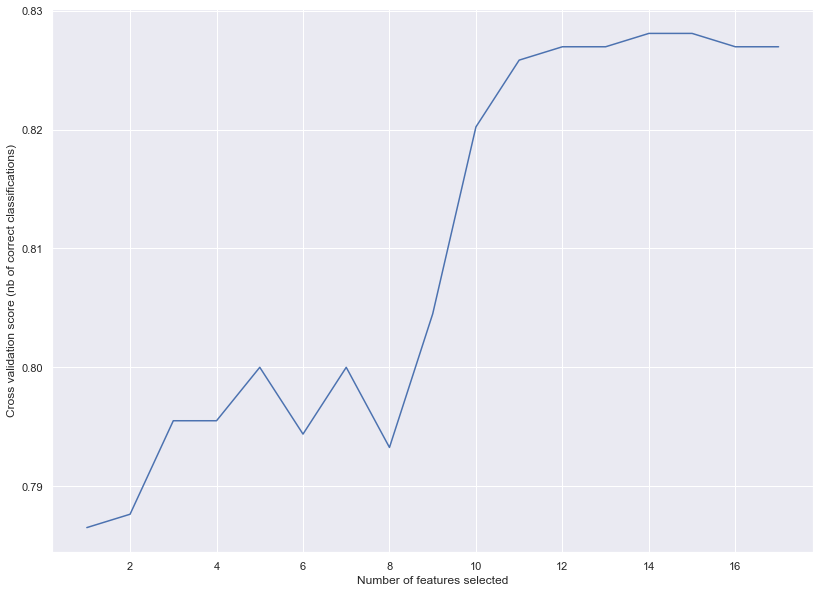

In [31]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=LogisticRegression(),scoring='accuracy')
rfecv.fit(x,y)
print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(x.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(30,10))
plt.subplot(1,2,1)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")

In [32]:
#features to use from RFECV
features_to_use = ['Age',\
                   'Title_Master.', 'Title_Miss.','Title_Mr.', 'Title_Mrs.', 'Title_Rare',\
                   'Pclass_1', 'Pclass_3',\
                   'Embarked_C', 'Embarked_S',\
                   'Sex_female', 'Sex_male',\
                   'TravelAlone', 'FamilySize']

In [33]:
#split training set into training and validation
from sklearn.model_selection import train_test_split

x = training[features_to_use]
y = training.iloc[:,0]

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2,random_state=42)

In [34]:
#Create and train model
logreg = LogisticRegression()

#normal data
logreg_model = logreg.fit(x_train, y_train)
y_pred = logreg_model.predict(x_val)
y_pred_proba = logreg_model.predict_proba(x_val)

# import the metrics class
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_val, y_pred)
print(cnf_matrix)
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))
print("Precision:",metrics.precision_score(y_val, y_pred))
print("Recall:",metrics.recall_score(y_val, y_pred))
print("F1 score:",metrics.f1_score(y_val, y_pred))

[[91 14]
 [13 60]]
Accuracy: 0.848314606741573
Precision: 0.8108108108108109
Recall: 0.821917808219178
F1 score: 0.8163265306122449


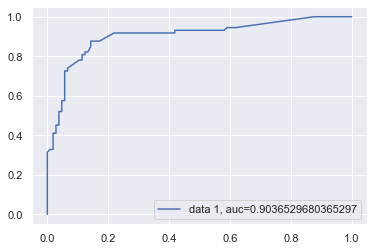

In [35]:
#Plot roc curve for both
fpr, tpr, thresholds = metrics.roc_curve(y_val,y_pred_proba[:,1])
auc = metrics.roc_auc_score(y_val, y_pred_proba[:,1])
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)

In [36]:
#now predicting test set
x_test = test[features_to_use]

#Results
y_test_pred = logreg_model.predict(x_test)
y_test_pred_proba = logreg_model.predict_proba(x_test)

sub = pd.DataFrame()

sub['PassengerId'] = raw_test_data['PassengerId']
sub['Survived'] = y_test_pred.astype(int)

sub.to_csv("submission_new_features.csv",header=True,index=False)

The logistic regression model is 